# Cell-cell communication (CCC)

## Introduction and installation

* Tool: CellphoneDB, liana, decoupler
* Github: None
* Paper: https://www.sc-best-practices.org/mechanisms/cell_cell_communication.html

In [1]:
# python libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import scanpy as sc
import liana as li
import decoupler as dc

import session_info

# import cellphonedb method via liana
from liana.method import cellphonedb
from liana.method import rank_aggregate

# Set the system path
import os
import sys
sys.path.append(os.path.abspath('../../'))

from Code.Utils.CCC import *

import warnings
warnings.filterwarnings('ignore')

In [2]:
# figure settings
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200, facecolor="white")
sc.set_figure_params(figsize=(9, 5))

In [3]:
# Read in
adata = sc.read("../../data/Preprocessed_data/harmony_cellmarkers.h5ad")
adata.obs_names_make_unique()
adata


AnnData object with n_obs × n_vars = 7391 × 33694
    obs: 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'cell_type'
    var: 'mean', 'std', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'batch_colors', 'cell_type_colors', 'dendrogram_cell_type', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap', 'ora_estimate', 'ora_pvals'
    varm: 'PCs'
    layers: 'log_norm', 'norm', 'raw', 'scale_data'
    obsp: 'connectivities', 'distances'

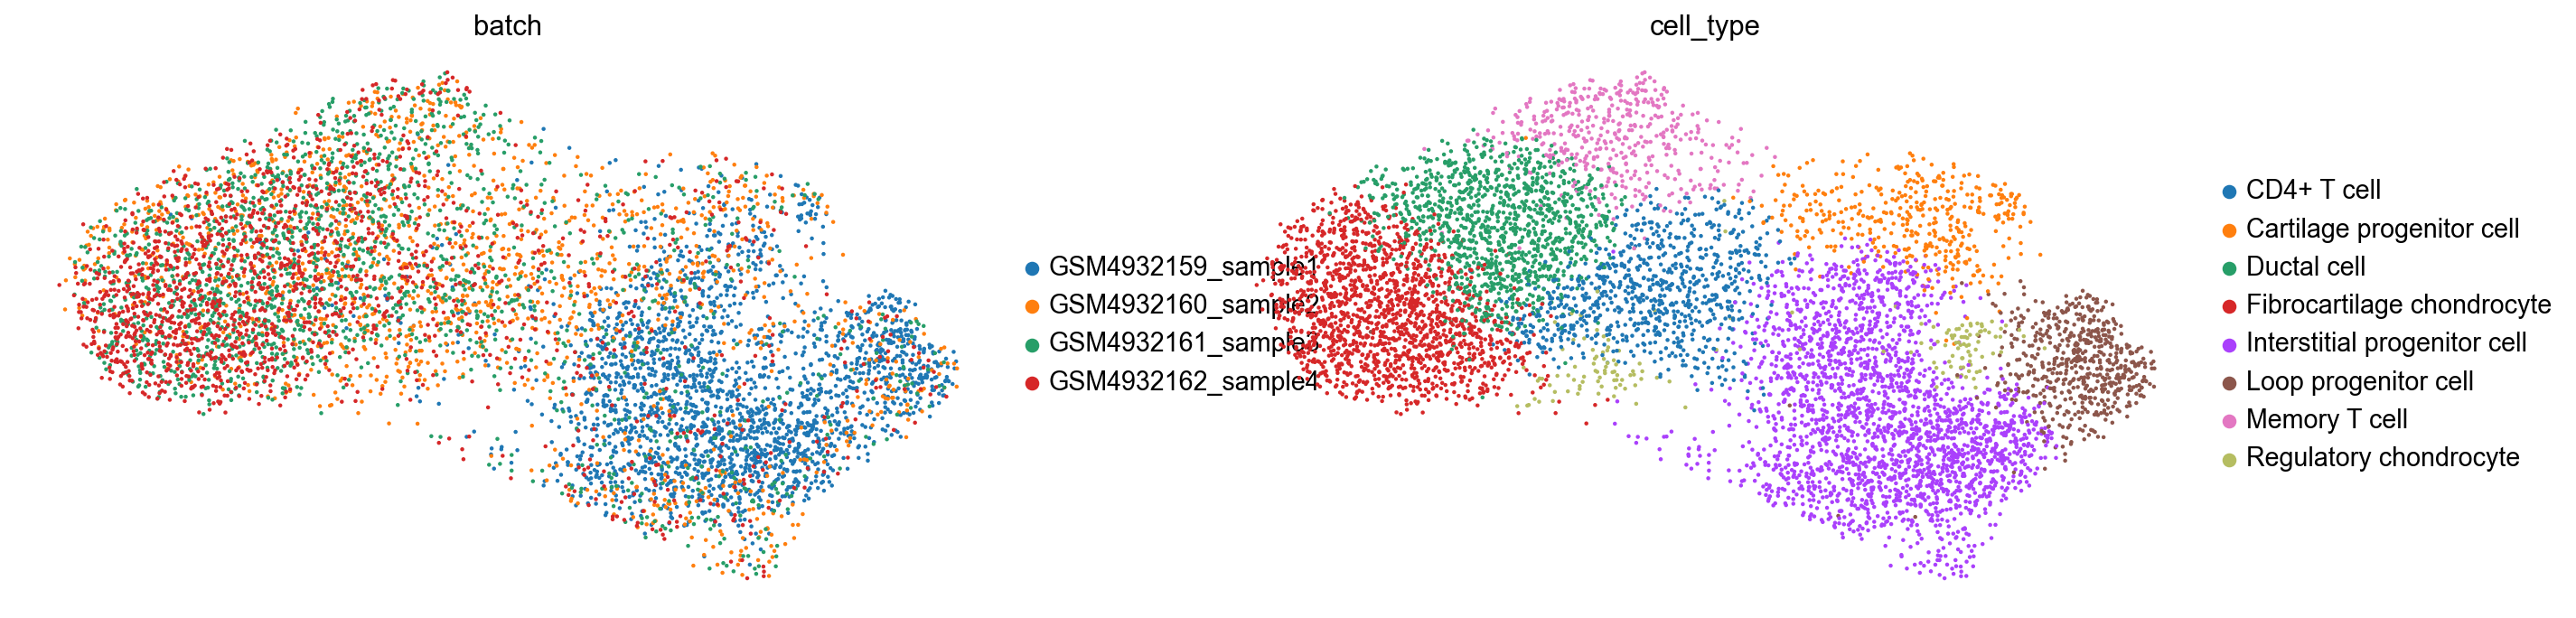

In [5]:
sc.pl.umap(adata, color=["batch", "cell_type"], frameon=False)

In [6]:
cellphonedb(
    adata, groupby="cell_type", use_raw=False, return_all_lrs=True, verbose=True
)

Using `.X`!
Converting to sparse csr matrix!
12390 features of mat are empty, they will be removed.
['RP11-442N24__B.1', 'RP11-99J16__A.2', 'RP11-544L8__B.4', 'RP11-524D16__A.3', 'RP11-1157N2__B.2', 'RP4-633O19__A.1'] contain `_`. Consider replacing those!
Using resource `consensus`.
0.32 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 7391 samples and 1150 features


100%|██████████| 1000/1000 [00:20<00:00, 49.37it/s]


In [7]:
adata.uns["liana_res"].head()

,ligand,ligand_complex,ligand_means,ligand_props,receptor,receptor_complex,receptor_means,receptor_props,source,target,lrs_to_keep,lr_means,cellphone_pvals
36440,CALM1,CALM1,0.382101,1.0,HMMR,HMMR,1.675231,1.0,Memory T cell,Cartilage progenitor cell,True,1.028666,0.0
24210,CALM1,CALM1,0.252696,1.0,HMMR,HMMR,1.675231,1.0,Cartilage progenitor cell,Cartilage progenitor cell,True,0.963964,0.0
31548,CALM1,CALM1,0.210917,1.0,HMMR,HMMR,1.675231,1.0,Interstitial progenitor cell,Cartilage progenitor cell,True,0.943074,0.0
133941,TIMP1,TIMP1,0.514081,1.0,CD63,CD63,1.293064,1.0,Memory T cell,Memory T cell,True,0.903573,0.0
140617,PTN,PTN,0.518862,1.0,PTPRS,PTPRS,1.284148,1.0,Cartilage progenitor cell,Regulatory chondrocyte,True,0.901505,0.0


Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


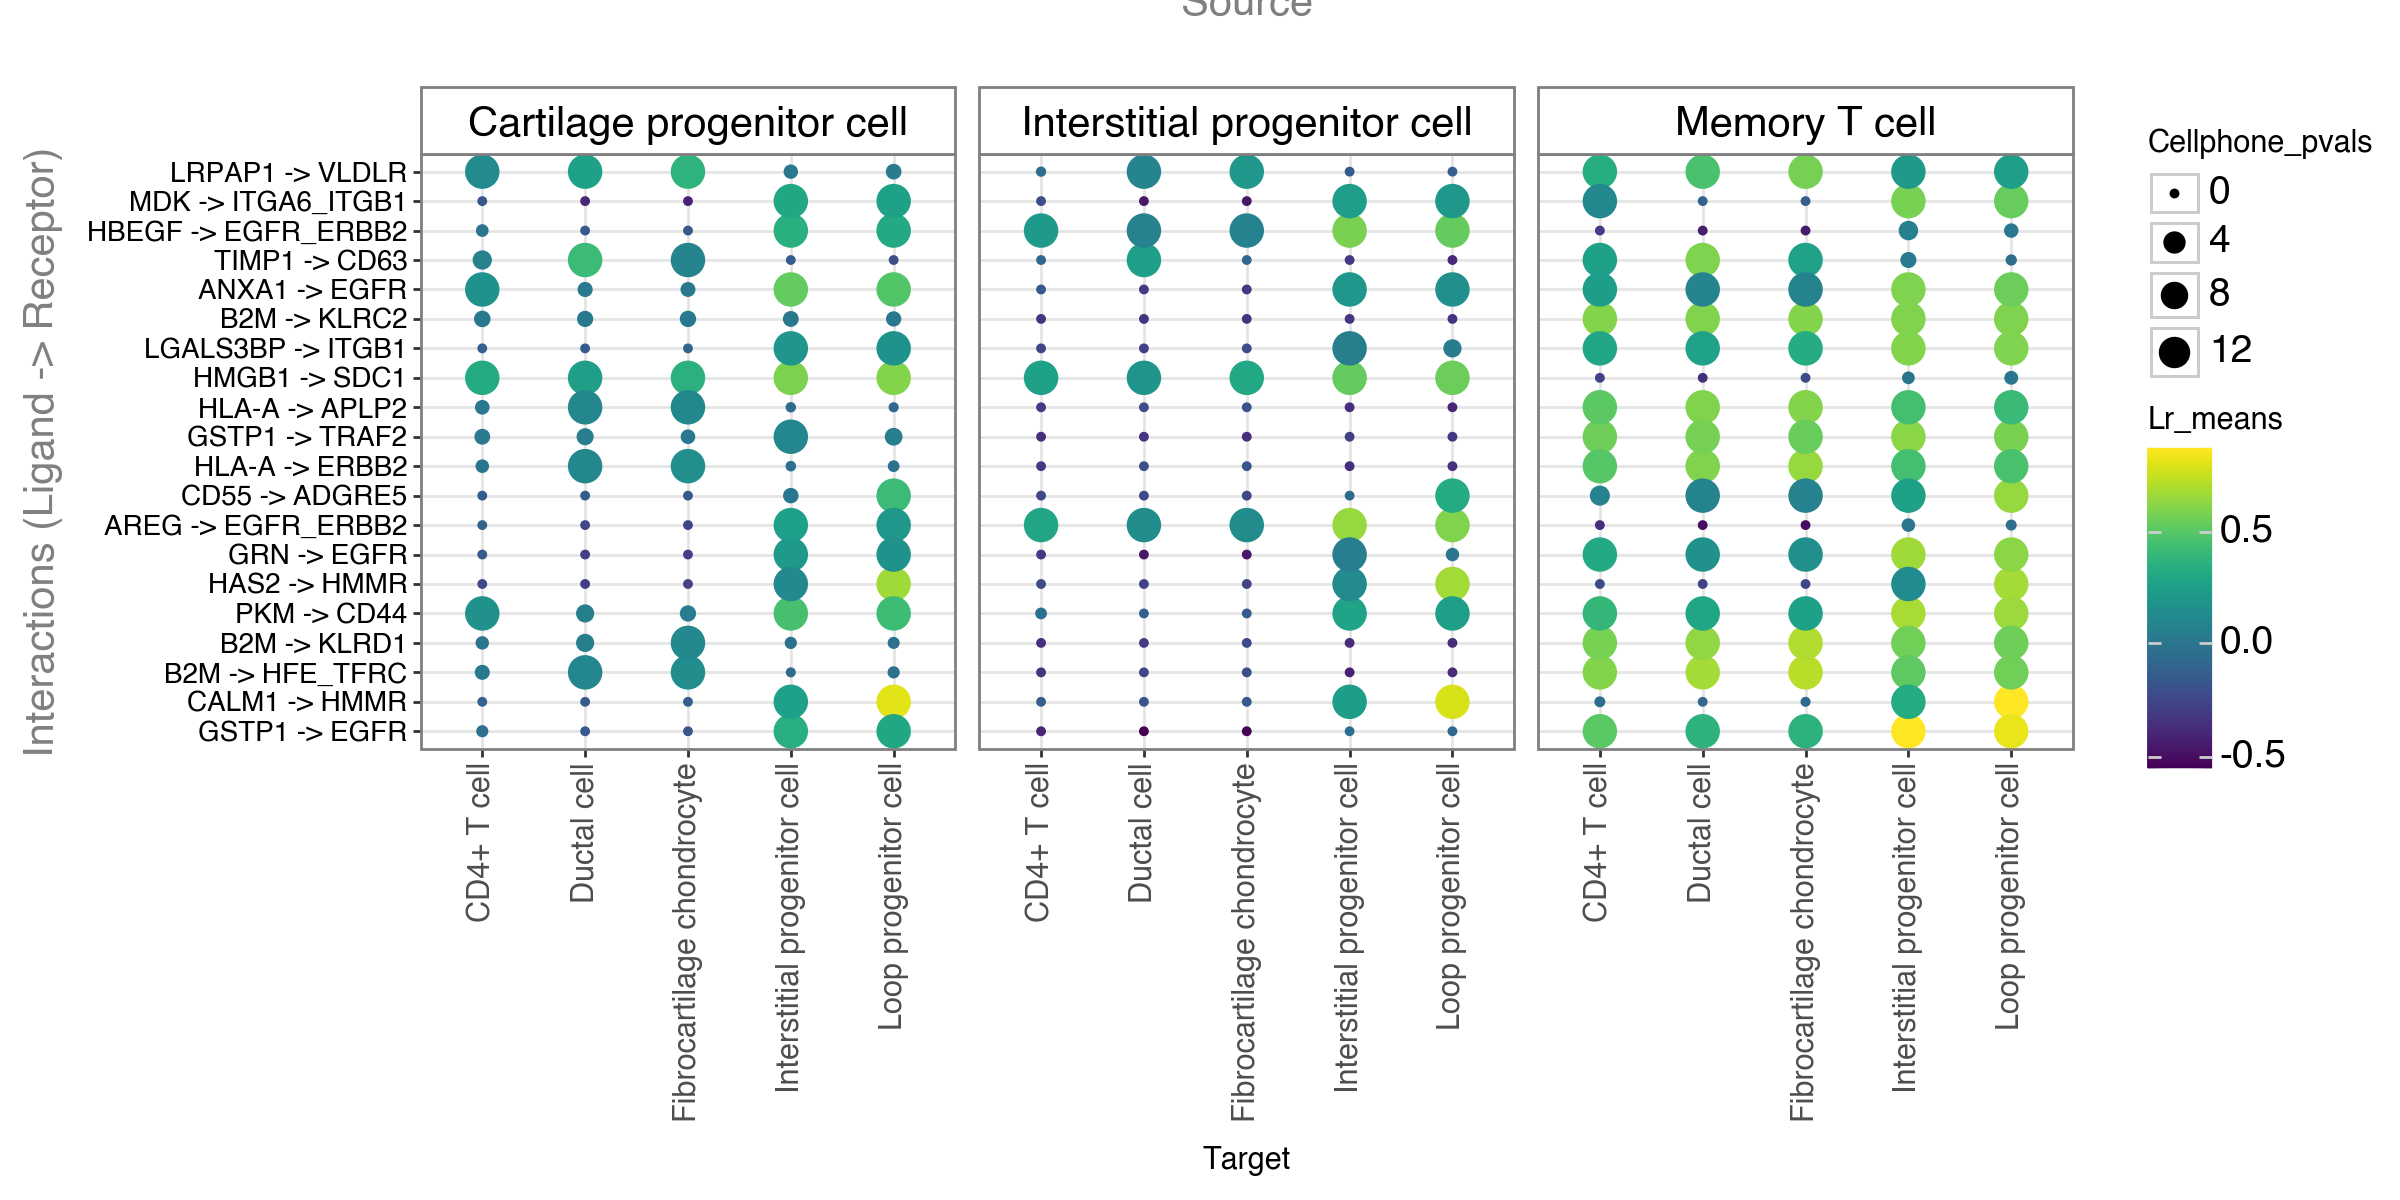

In [8]:
li.pl.dotplot(
    adata=adata,
    colour="lr_means",
    size="cellphone_pvals",
    inverse_size=True,  # we inverse sign since we want small p-values to have large sizes
    # We choose only the cell types which we wish to plot
    source_labels=adata.uns["liana_res"].source.unique()[:3],
    target_labels=adata.uns["liana_res"].target.unique()[3:],
    # since cpdbv2 suggests using a filter to FPs
    # we can filter the interactions according to p-values <= 0.01
    filter_fun=filter_func_cellphone_pvals,
    # as this type of methods tends to result in large numbers
    # of predictions, we can also further order according to
    # expression magnitude
    orderby="lr_means",
    orderby_ascending=False,  # we want to prioritize those with highest expression
    top_n=20,  # and we want to keep only the top 20 interactions
    figure_size=(12, 6),
    size_range=(1, 6),
)

In [9]:
li.method.show_methods()

,Method Name,Magnitude Score,Specificity Score,Reference
0,CellPhoneDB,lr_means,cellphone_pvals,"Efremova, M., Vento-Tormo, M., Teichmann, S.A...."
0,Connectome,expr_prod,scaled_weight,"Raredon, M.S.B., Yang, J., Garritano, J., Wang..."
0,log2FC,None,lr_logfc,"Dimitrov, D., Türei, D., Garrido-Rodriguez, M...."
0,NATMI,expr_prod,spec_weight,"Hou, R., Denisenko, E., Ong, H.T., Ramilowski,..."
0,SingleCellSignalR,lrscore,None,"Cabello-Aguilar, S., Alame, M., Kon-Sun-Tack, ..."
0,Rank_Aggregate,magnitude_rank,specificity_rank,"Dimitrov, D., Türei, D., Garrido-Rodriguez, M...."
0,Geometric Mean,lr_gmeans,gmean_pvals,CellPhoneDBv2's permutation approach applied t...
0,scSeqComm,inter_score,None,"Baruzzo, G., Cesaro, G., Di Camillo, B. 2022. ..."
0,CellChat,lr_probs,cellchat_pvals,"Jin, S., Guerrero-Juarez, C.F., Zhang, L., Cha..."


In [10]:
rank_aggregate(
    adata, groupby="cell_type", return_all_lrs=True, use_raw=False, verbose=True
)

Using `.X`!
Converting to sparse csr matrix!
12390 features of mat are empty, they will be removed.
['RP11-442N24__B.1', 'RP11-99J16__A.2', 'RP11-544L8__B.4', 'RP11-524D16__A.3', 'RP11-1157N2__B.2', 'RP4-633O19__A.1'] contain `_`. Consider replacing those!
Using resource `consensus`.
0.32 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 7391 samples and 1150 features
Assuming that counts were `natural` log-normalized!
Running CellPhoneDB


100%|██████████| 1000/1000 [00:19<00:00, 51.37it/s]


Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR


In [11]:
adata.uns["liana_res"].drop_duplicates(
    ["ligand_complex", "receptor_complex"]
).head()

,source,target,ligand_complex,receptor_complex,lr_means,cellphone_pvals,expr_prod,scaled_weight,lr_logfc,spec_weight,lrscore,specificity_rank,magnitude_rank
0,CD4+ T cell,CD4+ T cell,ACE,BDKRB2,-0.023789,0.686,0.000550,-0.018248,-4.152555,0.024103,NaN,1.000000,NaN
1,CD4+ T cell,CD4+ T cell,ACTR2,ADRB2,-0.025335,0.854,-0.000715,-0.025335,-0.229537,-0.072139,NaN,0.983755,NaN
2,CD4+ T cell,CD4+ T cell,ACTR2,LDLR,-0.023855,0.842,-0.000681,-0.023855,-0.017867,-0.135331,NaN,1.000000,NaN
3,CD4+ T cell,CD4+ T cell,ADA,DPP4,0.013636,0.083,-0.001886,0.014201,-2.353680,-0.080512,NaN,1.000000,NaN
4,CD4+ T cell,CD4+ T cell,ADAM10,AXL,-0.000811,0.509,-0.013606,-0.000811,-0.052569,0.042280,NaN,0.268218,NaN


Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


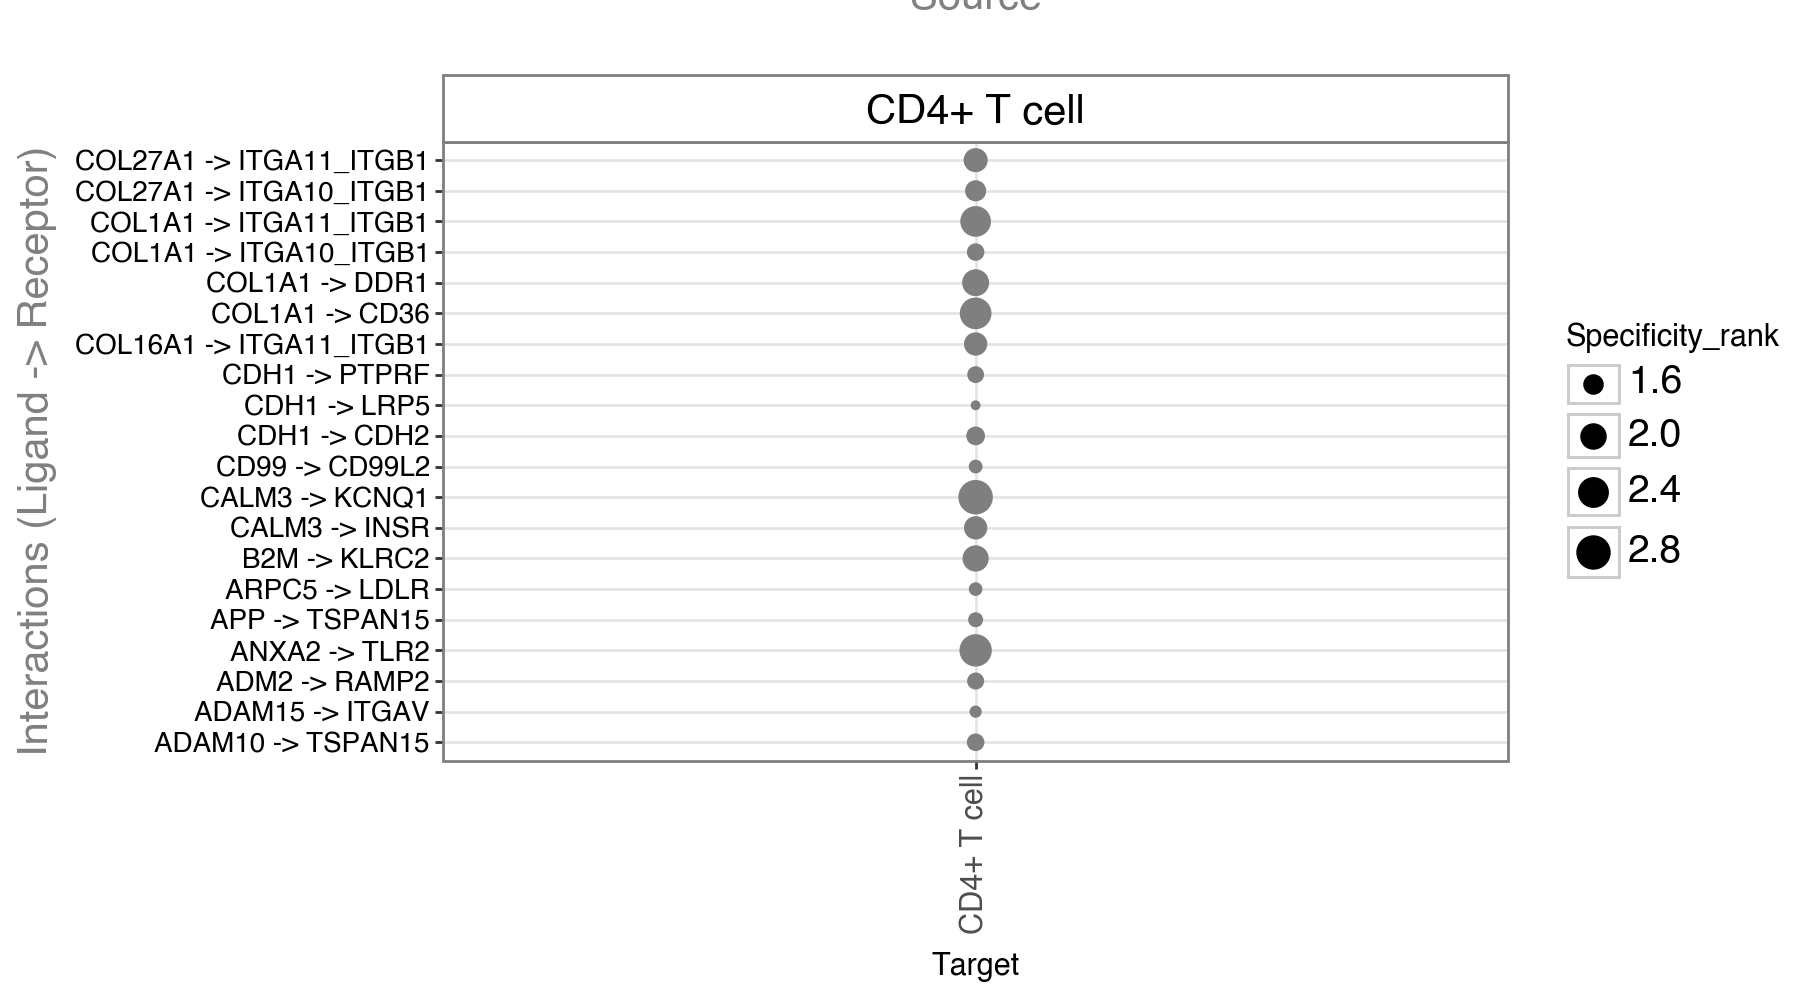

In [12]:
li.pl.dotplot(
    adata=adata,
    colour="magnitude_rank",
    size="specificity_rank",
    inverse_colour=True,  # we inverse sign since we want small p-values to have large sizes
    inverse_size=True,
    # We choose only the cell types which we wish to plot
    source_labels=['CD4+ T cell'],
    target_labels=["CD4+ T cell"],
    # since the rank_aggregate can also be interpreted as a probability distribution
    # we can again filter them according to their specificity significance
    # yet here the interactions are filtered according to
    # how consistently highly-ranked is their specificity across the methods
    filter_fun = filter_func_specificity_rank,
    # again, we can also further order according to magnitude
    orderby="magnitude_rank",
    orderby_ascending=True,  # prioritize those with lowest values
    top_n=20,  # and we want to keep only the top 20 interactions
    figure_size=(9, 5),
    size_range=(1, 6),
)